In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re, string, unicodedata
import nltk
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS #get_ipython().system('pip install wordcloud')
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # prevent showing future warning
pd.options.mode.chained_assignment = None 

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
tweet_input = pd.read_csv("covid19_tweets.csv")

### Data Overview

In [3]:
tweet_input.info()
tweet_input.isnull().sum()
tweet_input.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


### Data cleaning and processing

In [38]:
## filter tweet by hashtags that contains top 50 words
tweet= tweet_input['text']
def convert(lst):
    return ([i for item in lst for i in item.split()])
panda_df = pd.DataFrame(data =tweet_input, columns = ["text","hashtags"])
panda_df=panda_df[panda_df['hashtags'].notnull()]
df = pd.DataFrame(convert(panda_df['hashtags']))
df=df.replace(',','', regex=True)
df=df.replace("]",'', regex=True)
df=df.replace('\'','', regex=True)
df=df.replace('\[''', '', regex=True)
df=df.replace('ー', '', regex=True)
df=df.replace('_', '', regex=True)
df=df.replace('__', '', regex=True)
df.columns=['Words']
df['Words']=df['Words'].str.lower()
s=df.value_counts()
Words=pd.DataFrame(s.nlargest(50))
modified = Words.reset_index()
modified.columns=['Words',"Counts"]
#print(modified) 
selection = modified['Words'].tolist()
filtered_tweet=tweet_input[tweet_input['hashtags'].notnull()]
## hashtag count top 50
mask = filtered_tweet.hashtags.apply(lambda x: any(item for item in selection if item in x))
filtered_tweet=filtered_tweet[mask]

In [55]:
data = filtered_tweet[['user_name','date','text','hashtags','user_location']].reset_index(drop=True)
data

,user_name,date,text,hashtags,user_location
0,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Jammu and Kashmir
1,🎹 Franz Schubert,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Новоро́ссия
2,Prathamesh Bendre,2020-07-25 12:26:59,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",NaN
3,Beautify Data,2020-07-25 12:26:17,"An update on the total #covid19 cases, recover...","['covid19', 'Africa']","Miami, FL"
4,CARLINO,2020-07-25 12:25:29,Crazy that the world has come to this but as A...,['covid19'],"New Orleans, LA"
...,...,...,...,...,...
30121,Norwalk Library CT,2020-08-29 19:44:48,What are those #library #cats doing now? #COV...,"['library', 'cats', 'COVID19', 'pandemic', 'co...","Norwalk, CT"
30122,rainmaker,2020-08-29 19:44:35,@politvidchannel Just not the lives of #COVID1...,"['COVID19', 'coronavirus', 'TrumpVirus']",NaN
30123,Lori Comstock,2020-08-29 19:44:27,Wallkill school nurse adds COVID-19 monitoring...,"['nurses', 'COVID19', 'coronavirus', 'schools']","Newton, NJ"
30124,New Jersey Herald,2020-08-29 19:44:27,Wallkill school nurse adds COVID-19 monitoring...,"['nurses', 'COVID19', 'coronavirus', 'schools']","Newton, NJ"


In [41]:
tweet=data['text'].copy()
##remove website
tweet= tweet.str.replace(r"http\S+", "")
#remove hashtags
tweet = tweet.str.replace(r'#','', regex=True)
#remove mentions
tweet = tweet.str.replace(r'@[A-Za-z0-9_]+','', regex=True)
##remove punctuation
tweet = tweet.str.replace('[^\w\s]','')
 ##remove numbers
tweet = tweet.str.replace(r'\d+', '')
##remove underscore
tweet = tweet.str.replace(r"\W+_\W+", '', regex=True)
tweet = tweet.str.replace(r"_", '', regex=True)
##remove brackets
tweet = tweet.str.replace('\[.*?\]', '')
##convert to lower case
tweet= tweet.str.lower()
##drop empty rows
tweet.dropna(inplace=True)
##remove leading and ending white space
tweet = tweet.str.strip()
tweet = tweet.str.replace(r"\n", '', regex=True)
tweet = tweet.str.replace('  ', ' ', regex=True)
data['text']=tweet

def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

data['text'] =data.apply(lambda row: remove_non_ascii(row['text']), axis=1)

Mean:  0.03802224656442907
0.35708522518921537


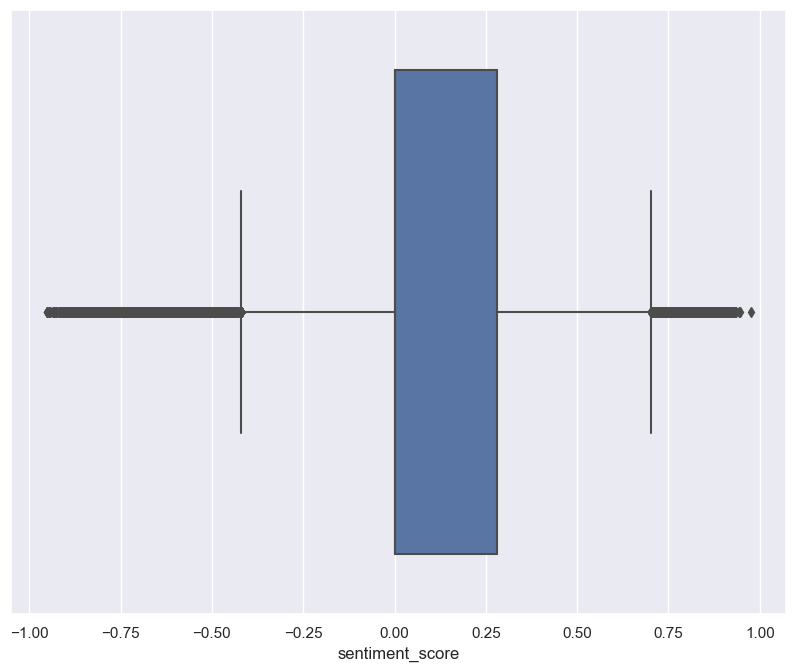

In [70]:
#use boxplot to check outlier
sns.boxplot(x=data['sentiment_score']) 
Q1 = data['sentiment_score'].quantile(0.25)
Q3 = data['sentiment_score'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
print("Mean: ",data['sentiment_score'].mean())
print(data['sentiment_score'].std())

# all data are within four std from the mean, so dont need to remove any data

### Sentiment Analysis using NLTK(nlp) 

In [57]:
# ref NLTK sentiment analyse https://www.nltk.org/howto/sentiment.html
#get_ipython().system('pip install vaderSentiment')
sentiment_analyzer = SentimentIntensityAnalyzer()
scores=[]
sentiment_=[]
sentiment_fit_=[]
for i in data['text']:
    sentiment_score = sentiment_analyzer.polarity_scores(i)
    score = sentiment_score['compound']
    scores.append(score)
data=data.assign(sentiment_score = scores)

for i in data['sentiment_score']:
    if i>0:
        sentiment='positive'
        sentiment_fit=1
    elif i==0:
        sentiment='neutral'
        sentiment_fit=0
    else:
        sentiment='negative'
        sentiment_fit=-1
    sentiment_.append(sentiment)
    sentiment_fit_.append(sentiment_fit)
data=data.assign(sentiments=sentiment_)
data=data.assign(sentiment_fit=sentiment_fit_)
data.head()

,user_name,date,text,hashtags,user_location,sentiment_score,sentiments,sentiment_fit
0,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Jammu and Kashmir,0.3182,positive,1
1,🎹 Franz Schubert,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Новоро́ссия,-0.4976,negative,-1
2,Prathamesh Bendre,2020-07-25 12:26:59,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",NaN,0.6597,positive,1
3,Beautify Data,2020-07-25 12:26:17,"An update on the total #covid19 cases, recover...","['covid19', 'Africa']","Miami, FL",0.0000,neutral,0
4,CARLINO,2020-07-25 12:25:29,Crazy that the world has come to this but as A...,['covid19'],"New Orleans, LA",-0.6588,negative,-1


### Machine learning Model Training and Testing

In [71]:
# ref https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#selected=data.iloc[0:5000]
description_list = []
vectorizer = CountVectorizer(stop_words='english',lowercase=False)
for text in data['text']:
    tokenize=nltk.word_tokenize(text)
    words=[]
    for i in tokenize:
        lemma = nltk.WordNetLemmatizer()
        word=lemma.lemmatize(i)
        words.append(word)
    words_=' '.join(words)
    description_list.append(words_)
X = vectorizer.fit_transform(description_list).toarray()
y = data['sentiment_fit']
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.4, random_state = 42)


nb=GaussianNB()
nb.fit(X_train,y_train)
#Test
y_pred=nb.predict(X_valid)
print("Navie Bayes algorithm accuracy=",nb.score(X_valid,y_valid)*100)


knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_valid)
print("Knn algorithm accuracy=",knn.score(X_valid,y_valid)*100)

model = MultinomialNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
print("multinomial Naive Bayes classifier accuracy=",model.score(X_valid,y_valid)*100)

rf_model = RandomForestClassifier(n_estimators=100,random_state=1)
rf_model.fit(X_train, y_train)
print("RandomForest accuracy=",rf_model.score(X_valid,y_valid)*100)

lr=LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression algorithm accuracy =",lr.score(X_train, y_train)*100)


NN_model= MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
NN_model.fit(X_train, y_train)
print("Multi-layer Perceptron accuracy =",NN_model.score(X_train, y_train)*100)

models = pd.DataFrame({
    'Model': ['Navie Bayes', 'K-Nearest Neighbors', 
              'Multinomial Naive Bayes', 'Random Forest', 
              'Logistic Regression', 'Multi-layer Perceptron'],
    'Test accuracy': [nb.score(X_valid,y_valid)*100, 
                      knn.score(X_valid,y_valid)*100,
                      model.score(X_valid,y_valid)*100, 
                      rf_model.score(X_valid,y_valid)*100,
                      lr.score(X_train, y_train)*100, 
                      NN_model.score(X_train, y_train)*100]})

models.sort_values(by='Test accuracy', ascending=False)

Navie Bayes algorithm accuracy= 51.949999999999996
Knn algorithm accuracy= 52.449999999999996
multinomial Naive Bayes classifier accuracy= 65.14999999999999
RandomForest accuracy= 66.8


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression algorithm accuracy = 99.9
Multi-layer Perceptron accuracy = 100.0


,Model,Test accuracy
5,Multi-layer Perceptron,100.00
4,Logistic Regression,99.90
3,Random Forest,66.80
2,Multinomial Naive Bayes,65.15
1,K-Nearest Neighbors,52.45
0,Navie Bayes,51.95


### Exploratory Data Analysis

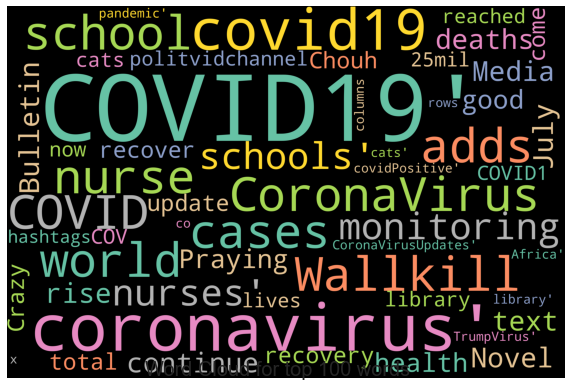

In [26]:
# WordCloud
df_wordcloud=data[['text','hashtags']]
word_cloud = WordCloud(background_color='black',colormap='Set2',stopwords=set(STOPWORDS),max_words=100,width = 3000, height = 2000,random_state=1,collocations=False).generate(str(df_wordcloud))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 100 words', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

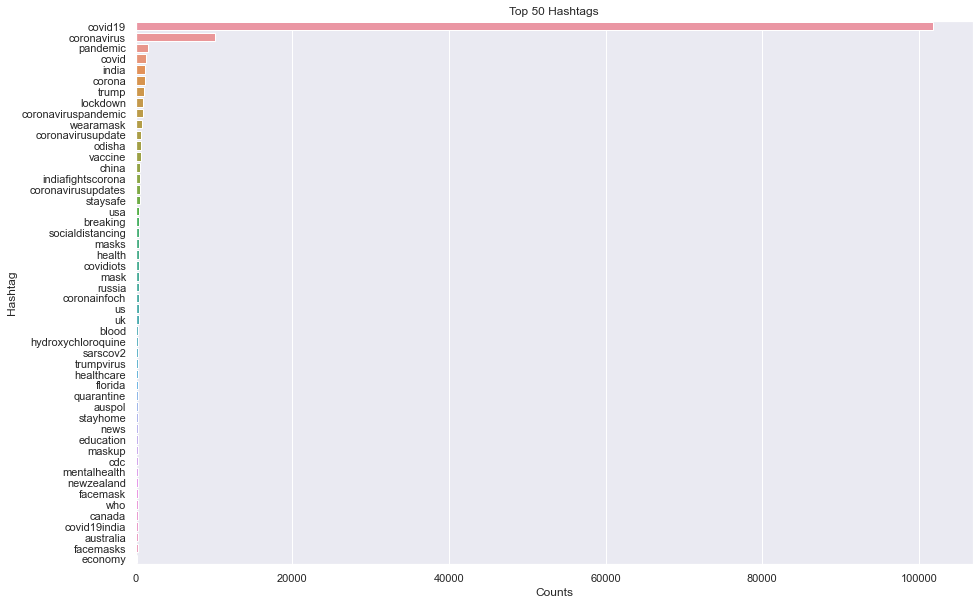

In [39]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,10))
sns.barplot(modified["Counts"],modified["Words"])
plt.title("Top 50 Hashtags")
plt.xlabel("Counts")
plt.ylabel("Hashtag")
plt.show()

In [ ]:
data_agg=data[['date','sentiments','text']]
data_agg['date'] =  pd.to_datetime(data_agg['date']).dt.date 
groups=data_agg.groupby(['date','sentiments'])
data_agg =groups.aggregate('count').reset_index()
data_agg=data_agg.rename(columns={'text': 'tweet_count'})

sns.lineplot(data=data_agg, x="date", y="tweet_count", hue="sentiments")
plt.xticks(rotation = 30)

In [ ]:
#data_agg.groupby('sentiments').sum() to get the count numbers
data_sum=[30945,40239,40999]
data_label=['Negative', 'Netural', 'Positive']
colors = sns.color_palette('bright')[7:10]
plt.pie(data_sum,labels = data_label, colors = colors, autopct='%.0f%%')

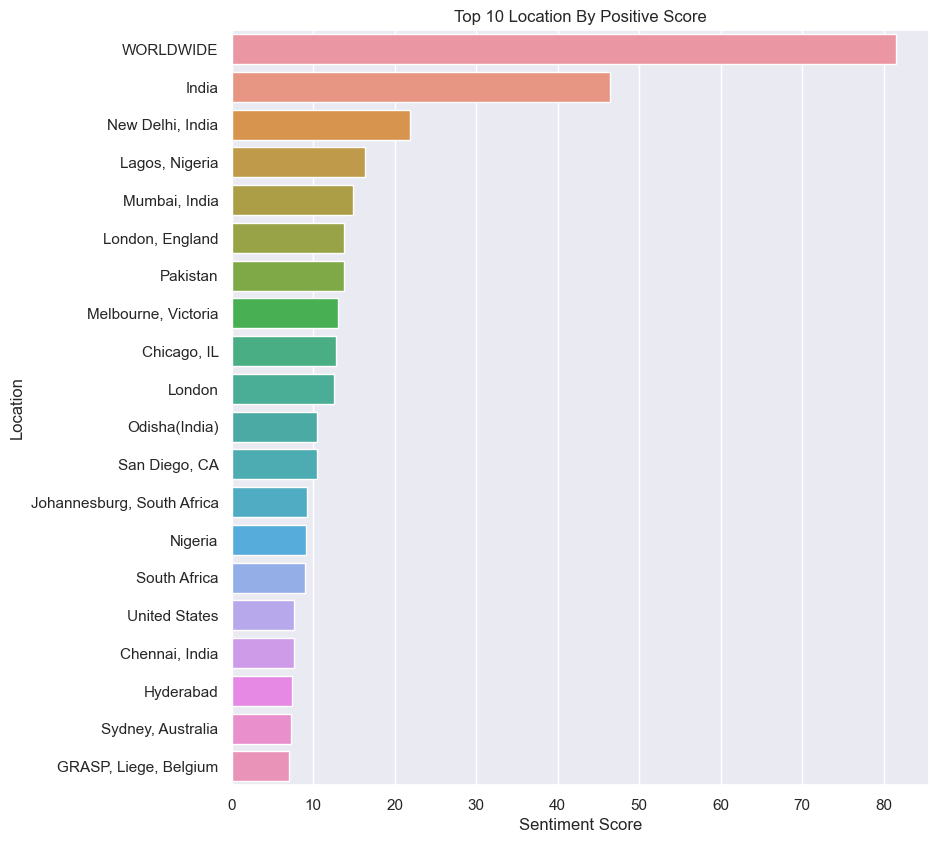

In [58]:
countries = pd.DataFrame()
countries["Score"] = data["sentiment_score"]
countries["user_location"] = data["user_location"]
countries = countries.sort_values(by = "Score",ascending=False)
countries = countries.groupby("user_location").sum().sort_values(by = "Score",ascending=False)[:20]

plt.figure(figsize=(9,10))
sns.barplot(list(countries.values.flatten()),countries.index,)
plt.title("Top 10 Location By Positive Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Location")
plt.show()

In [ ]:
## Numerical Summary 
dataa=pd.DataFrame(data[['date','sentiments']])


dataa['date'] = pd.to_datetime(dataa['date'], format='%Y-%m-%d %H:%M:%S',)
dataa['Day'] = [d.date() for d in dataa['date']]
dataa['Time'] = [d.time() for d in dataa['date']]

day_sentiments = dataa.groupby(['Day', 'sentiments']).agg({'Time': 'count'})
day_total = dataa.groupby(['Day']).agg({'Time': 'count'})

pd.set_option("display.max_rows", None, "display.max_columns", None)
day_sentiments.div(day_total, level='Day').round(3) * 100

fit.slope: -4.9640673512541636e-09
fit.intercept 7.965176406234063
fit.pvalue 0.0313195789475605


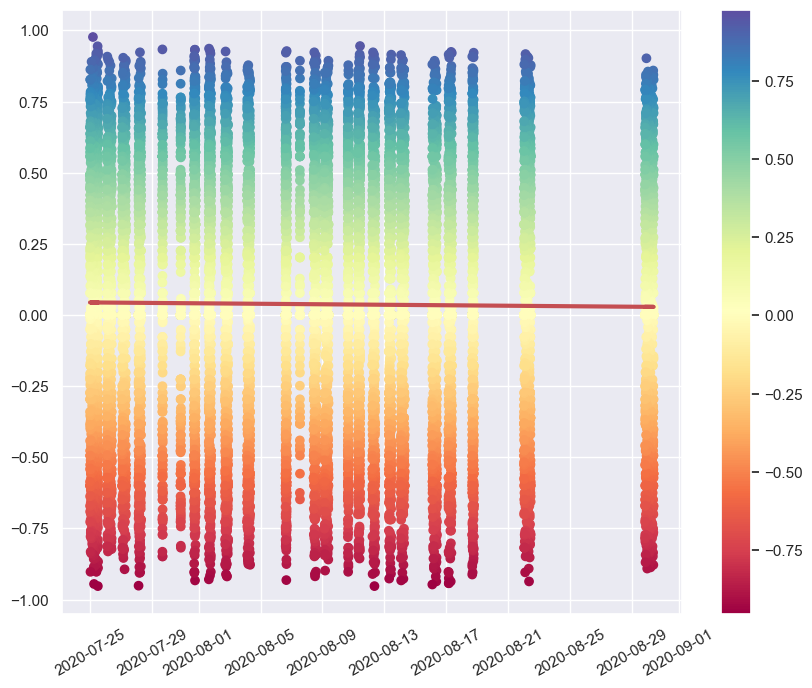

In [60]:
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
def to_timestamp(t):
    return datetime.timestamp(t)
data['timestamp'] = data['date'].apply(to_timestamp)
fit = stats.linregress(data['timestamp'] , data['sentiment_score'])
data['prediction'] = data['timestamp']*fit.slope + fit.intercept
print("fit.slope:",fit.slope)
#fit.slope<0, so the sentimen_score has a slight decrease during the period
print("fit.intercept",fit.intercept)
print("fit.pvalue", fit.pvalue) 
##since p value<0.05, reject H0, the ratings has been changing over time
plt.xticks(rotation = 30)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(data['date'] , data['sentiment_score'], c=data['sentiment_score'], cmap='Spectral')
plt.colorbar()
plt.plot(data['date'] , data['timestamp']*fit.slope + fit.intercept , 'r-' , linewidth =3)

(array([  433.,  1586.,  2148.,  1875., 13638.,  2106.,  2366.,  3743.,
         1734.,   497.]),
 array([-0.996397  , -0.80349064, -0.61058427, -0.41767791, -0.22477154,
        -0.03186517,  0.16104119,  0.35394756,  0.54685392,  0.73976029,
         0.93266665]),
 <BarContainer object of 10 artists>)

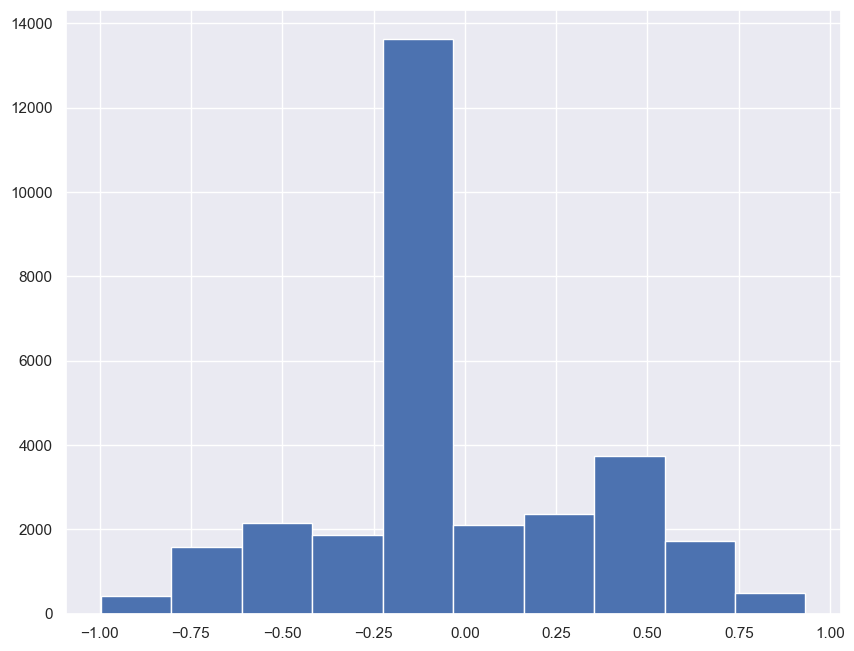

In [61]:
residuals=data['sentiment_score']-data['prediction']
plt.hist(residuals)#the requirement of normality can be softened with kind-of-normal data and n>=40

In [ ]:

data_raw = "读入的数据".split('\n') # 按行分隔
data_blue = []
data_red = []
word_count_blue = {}
word_count_red = {}
for line_data in data_raw:
    word_list = line_data.split(" ") # 分隔单词
    if word_list[0] == "BLUE":
        for i in range(1,len(word_list)):
            if not is_excluded(word_list[i]): # 判断是否为停用词
                data_blue.append(word_list[i])
                # 统计单词出现次数
                word_count_blue.setdefault(word_list[i], 0)
                word_count_blue[word_list[i]] += 1
    elif word_list[0] == "RED":